# Questions:

How has the sentiment of congressional tweets changed over time from 2008-2017?

Who are the most mentioned individuals or groups in congressional tweets, and has this changed over time?

# Hypotheses:

There may be a general trend towards increased negativity or polarization in congressional tweets over time, especially in response to major political events or changes in Congress.

The most mentioned individuals or groups in congressional tweets may shift over time depending on current events and political climates.


# Approach:

I will begin by exploring the 'text' and 'created_at' fields in the dataset to understand the content and timing of the tweets. Next, I will calculate sentiment scores using the TextBlob library and analyze any trends in sentiment over time. To answer the second question, I will look at the most common mentions in the tweets using regular expressions or entity recognition libraries such as spaCy. 

In [1]:
import pandas as pd
import plotly.express as px
import math

In [2]:
from sqlalchemy import create_engine

# Define the connection string
conn_str = (
    r'DRIVER={ODBC Driver 17 for SQL Server};'
    r'SERVER=localhost;'
    r'DATABASE=portfolioDB;'
    r'UID=sa;'
    r'PWD=Mym0901!'
)

# Define the database URL using the mssql+pyodbc dialect and pass in the connection string
database_url = f'mssql+pyodbc:///?odbc_connect={conn_str}'

# Create a SQLAlchemy engine object
engine = create_engine(database_url)

# Test the connection by executing a SQL query
result = engine.execute('SELECT @@version').fetchone()
print(result[0])

Microsoft Azure SQL Edge Developer (RTM) - 15.0.2000.1574 (ARM64) 
	Jan 25 2023 10:36:08 
	Copyright (C) 2019 Microsoft Corporation
	Linux (Ubuntu 18.04.6 LTS aarch64) <ARM64>


In [3]:
from sqlalchemy import MetaData

# create a metadata object
metadata = MetaData()

# reflect the metadata of the database
metadata.reflect(bind=engine)

# print the list of table names in the database
print(metadata.tables.keys())


dict_keys(['course_type_category', 'coursea_data', 'edx_courses', 'findings', 'game_data', 'gun_backup', 'gun_death_by_country', 'gun_law_by_country', 'level_category', 'pivot_table', 'Player_attacked_square_info', 'Player_piece', 'Player_piece_sac_data', 'tweets', 'tweetsss'])


In [4]:
# import pandas as pd

# # Read the JSON file into a Pandas DataFrame
# df = pd.read_json('tweetssss.json', lines = True)

# # Write the DataFrame to a CSV file
# df.to_csv('tweetsss.csv', index=False)


In [5]:
query = "SELECT * FROM tweetsss"
tweets = pd.read_sql(query, engine)
tweets.to_pickle('tweetsss.pkl')
tweets.info()
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243400 entries, 0 to 1243399
Data columns (total 32 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   contributors               30 non-null       object 
 1   coordinates                2762 non-null     object 
 2   created_at                 1243398 non-null  object 
 3   display_text_range         1243384 non-null  object 
 4   entities                   1243374 non-null  object 
 5   favorite_count             1243370 non-null  float64
 6   favorited                  1243370 non-null  object 
 7   geo                        2734 non-null     object 
 8   id                         1243370 non-null  object 
 9   id_str                     1243370 non-null  object 
 10  in_reply_to_screen_name    65411 non-null    object 
 11  in_reply_to_status_id      54146 non-null    float64
 12  in_reply_to_status_id_str  54146 non-null    float64
 13  in_reply_to_

/var/folders/9l/b751j3yd3x752qk2fqk6j6zc0000gn/T/ipykernel_35540/1436042267.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [6]:
tweets.isnull().sum()

contributors                 1243370
coordinates                  1240638
created_at                   2      
display_text_range           16     
entities                     26     
favorite_count               30     
favorited                    30     
geo                          1240666
id                           30     
id_str                       30     
in_reply_to_screen_name      1177989
in_reply_to_status_id        1189254
in_reply_to_status_id_str    1189254
in_reply_to_user_id          1177989
in_reply_to_user_id_str      1177989
is_quote_status              30     
lang                         30     
place                        1220950
retweet_count                30     
retweeted                    30     
screen_name                  30     
source                       83     
text                         30     
truncated                    58     
user_id                      58     
possibly_sensitive           473234 
extended_entities            945364 
q

In [7]:
# Check the data types of the text and created_at fields
print(tweets['text'].dtype)
print(tweets['created_at'].dtype)

# Convert the date column to a datetime object
tweets['created_at'] = pd.to_datetime(tweets['created_at'], errors='coerce')

# Check for missing values in the date column
print(tweets['created_at'].isnull().sum())

object
object
30


In [8]:
# Extract the year, month, and day from the created_at field
tweets['year'] = tweets['created_at'].dt.year
tweets['month'] = tweets['created_at'].dt.month
tweets['day'] = tweets['created_at'].dt.day

# Group the data by the year, month, and day fields
tweets_per_day = tweets.groupby(['year', 'month', 'day']).size().reset_index(name='count')

# Get summary statistics for the 'count' field
print(tweets_per_day['count'].describe())

count    3110.000000
mean     399.797428 
std      505.788598 
min      1.000000   
25%      43.000000  
50%      172.000000 
75%      591.500000 
max      4056.000000
Name: count, dtype: float64


created_at
2008-08-31    10   
2008-09-30    21   
2008-10-31    8    
2008-11-30    19   
2008-12-31    54   
              ..   
2017-02-28    39871
2017-03-31    54262
2017-04-30    39364
2017-05-31    45420
2017-06-30    6269 
Name: text, Length: 107, dtype: int64


<AxesSubplot: xlabel='created_at'>

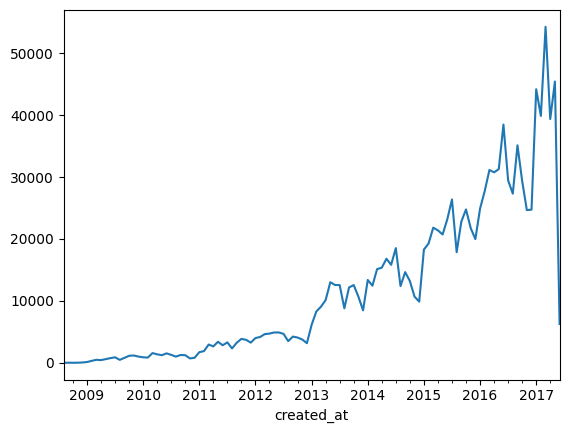

In [9]:
# Group the data by month and count the number of tweets
monthly_counts = tweets.groupby(pd.Grouper(key='created_at', freq='M'))['text'].count()
print(monthly_counts)

# Plot the data
monthly_counts.plot()

In [10]:
import matplotlib.pyplot as plt
from textblob import TextBlob

# Conver 'text' field to String
tweets['text'] = tweets['text'].astype(str)

# Use the TextBlob library to perform sentiment analysis on the text field
tweets['sentiment'] = tweets['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

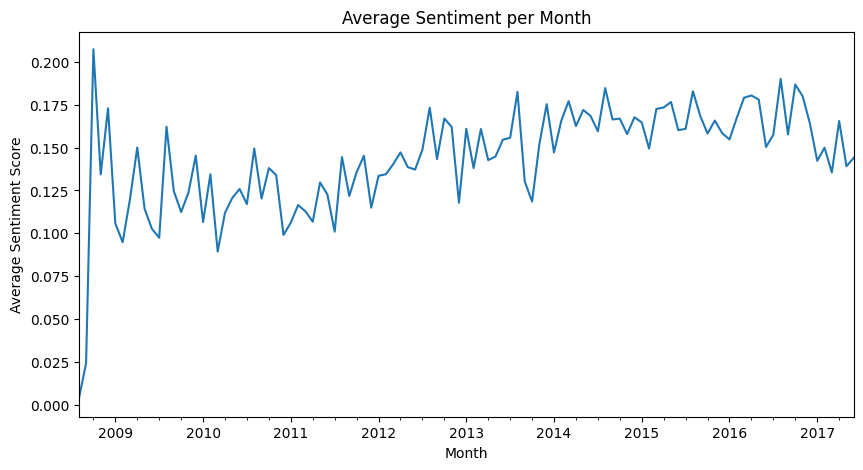

In [11]:
# Group the data by month
avg_sentiment_per_month = tweets.groupby(pd.Grouper(key = 'created_at', freq='M'))['sentiment'].mean()

# plot the results
avg_sentiment_per_month.plot(kind='line', figsize=(10, 5))
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment per Month')
plt.show()

The sentiment score is above zero, which indicates that the tweets were more positive than negative

## Frequency of each hashtag

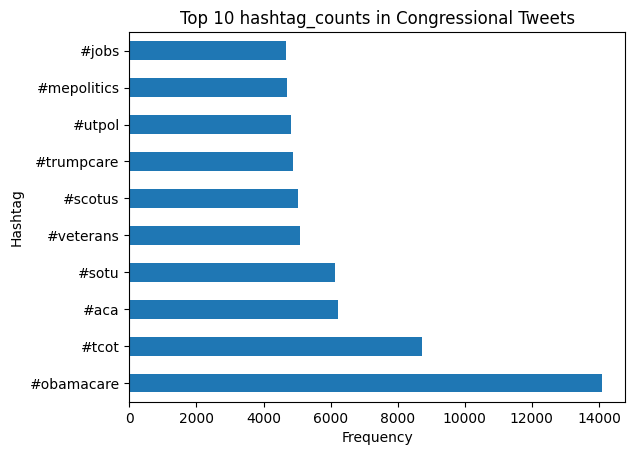

In [12]:
import re

# Drop any rows with None values in the 'text' column
tweets = tweets.dropna(subset=['text'])

# Extract all the hashtag_counts from the tweets
hashtag_counts = tweets['text'].apply(lambda x: re.findall(r'\#\w+', x))

# Flatten the list of hashtag_counts
hashtag_counts = [item.lower() for sublist in hashtag_counts for item in sublist]

# Count the frequency of each hashtag
hashtag_counts = pd.Series(hashtag_counts).value_counts().sort_values(ascending=False)

# Plot the top 20 hashtag_counts
hashtag_counts.head(10).plot(kind='barh')
plt.xlabel('Frequency')
plt.ylabel('Hashtag')
plt.title('Top 10 hashtag_counts in Congressional Tweets')
plt.show()

In [13]:
# filter tweets with the #Obamacare hashtag
obama_care_tweets = tweets[tweets['text'].str.contains('#Obamacare')]

# calculate sentiment for each tweet
sentiment_scores = []
for tweet in obama_care_tweets['text']:
    blob = TextBlob(tweet)
    sentiment_scores.append(blob.sentiment.polarity)

# calculate average sentiment score
avg_sentiment = sum(sentiment_scores) / len(sentiment_scores)

print('Average sentiment score for #Obamacare tweets:', avg_sentiment)

Average sentiment score for #Obamacare tweets: 0.05039854708150704


<AxesSubplot: ylabel='hashtag'>

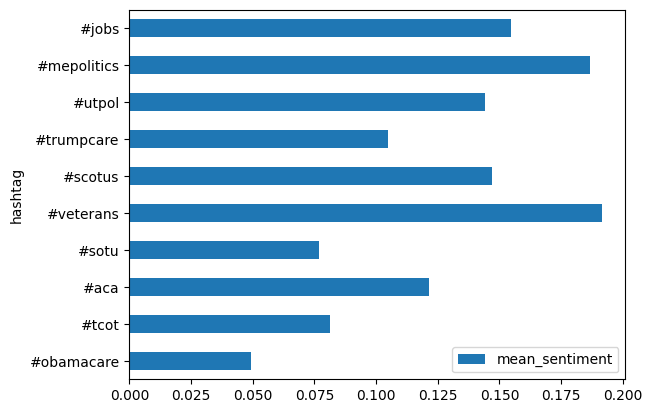

In [14]:
hashtag_list = hashtag_counts.sort_values(ascending=False).head(10)
from textblob import TextBlob
hashtag_sentiment = pd.DataFrame(columns = ['hashtag','mean_sentiment'])
for hashtag,count in hashtag_list.items():
    hashtag_text = tweets[tweets['text'].str.contains(hashtag)]
    df = pd.DataFrame(columns = ['text', 'sentiment'])
    for tweet in hashtag_text['text']:
        blob = TextBlob(tweet)
        sentiment = blob.sentiment.polarity
        df = pd.concat([df, pd.DataFrame({'text': [tweet], 'sentiment': [sentiment]})], ignore_index=True)
    mean_sentiment = df['sentiment'].mean()
    hashtag_sentiment = pd.concat([hashtag_sentiment, pd.DataFrame({'hashtag': [hashtag], 'mean_sentiment': [mean_sentiment]})], ignore_index=True)
hashtag_sentiment.plot.barh(x='hashtag', y='mean_sentiment')

/Users/minhnguyen/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


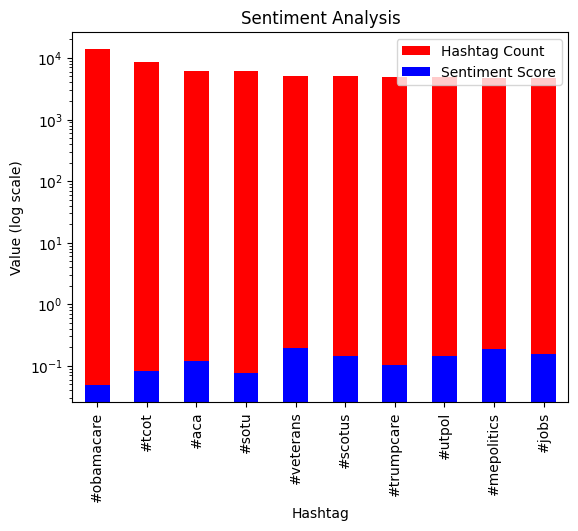

In [15]:
# create a figure and axis object
fig, ax = plt.subplots()

# plot the two bar charts on the same axis
hashtag_counts.plot.bar(x='hashtag', y='count', ax=ax, color='red', label='Hashtag Count')
hashtag_sentiment.plot.bar(x='hashtag', y='mean_sentiment', ax=ax, color='blue', label='Sentiment Score')

# set the x and y axis labels
ax.set_yscale('log')
ax.set_xlabel('Hashtag')
ax.set_ylabel('Value (log scale)')

# set the title of the graph
ax.set_title('Sentiment Analysis')

# display the legend
ax.legend()

# show the plot
plt.show()


# Who are the most mentioned individuals or groups in congressional tweets, and has this changed over time?

In [16]:
# Create a counting function to count each time an individual is mentioned 
def counter(dataframe):
    # Extract the "text" column
    text_column = dataframe["text"]

    # Create an empty dictionary to store the count of each Twitter handle
    handle_counts = {}

    # Loop through each tweet
    for text in text_column:
        # Use regular expressions to find all Twitter handles in the text
        handles = re.findall(r'(?<!\w)@(\w+)', text)
        
        # Loop through each handle and update the count in the dictionary
        for handle in handles:
            if handle in handle_counts:
                handle_counts[handle] += 1
            else:
                handle_counts[handle] = 1

    # Sort the dictionary by count in descending order
    sorted_handles = sorted(handle_counts.items(), key=lambda x: x[1], reverse=True)
    return sorted_handles

# Print the top 10 most mentioned handles
sorted_handles = counter(tweets)
for handle, count in sorted_handles[:10]:
        print(handle, count)

POTUS 13995
HouseGOP 10893
realDonaldTrump 6479
SpeakerRyan 5573
SpeakerBoehner 4397
HouseDemocrats 4035
WhiteHouse 3798
HouseCommerce 3679
FoxNews 3324
WaysandMeansGOP 2671


In [17]:
# Filter the dataset to only include tweets from 2009-2017
start_year = 2009
end_year = 2017
tweets_select = tweets[(tweets["created_at"].dt.year >= start_year) & (tweets["created_at"].dt.year <= end_year)]

# Group the dataset by year
grouped_tweets = tweets_select.groupby(tweets_select['created_at'].dt.year)

top_handles_dict = {}

# Loop through each year
for year, year_group in grouped_tweets:
    # Extract the "text" column for the current year
    sorted_handles = counter(year_group)

     # Store the top 10 most mentioned handles for the current year in a dictionary
    top_handles_dict[year] = {}
    for handle, count in sorted_handles[:10]:
        top_handles_dict[year][handle] = count

In [18]:
# create an empty list to store the data
data = []

# loop through the dictionary
for year, handles in top_handles_dict.items():
    # loop through the handles for each year
    for handle, count in handles.items():
        # append the year, handle and count as a tuple to the data list
        data.append((year, handle, count))

In [30]:
df_raw = pd.DataFrame(data, columns=['year', 'handle', 'count'])

keep = []
for year in set(df_raw['year']):
    df = df_raw[df_raw['year'] == year].copy()  # create a copy to avoid the warning
    order = df['count'].rank(ascending=0)
    df.loc[:, 'rank'] = order.astype(int)
    keep.append(df)

# combine the separate dataframes back into one
df = pd.concat(keep)
df = df.sort_values(by = 'year')
df

,year,handle,count,rank
8,2009,NASA,14,9
6,2009,addthis,18,7
5,2009,pawatercooler,22,6
4,2009,GOPConference,24,5
3,2009,RogerLau,28,4
2,2009,GOPLeader,33,3
1,2009,gopconference,36,2
0,2009,capuano4senate,94,1
9,2009,RepMikePence,14,9
7,2009,HouseFloor,17,8


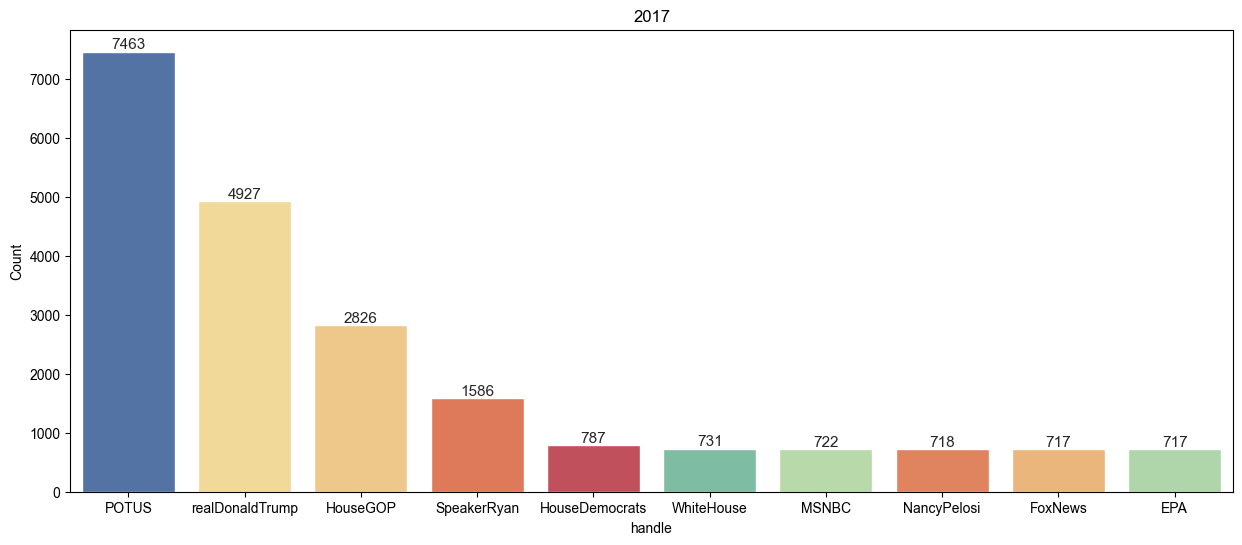

In [20]:
import seaborn as sns

#extract color palette, the palette can be changed
dict_color = {}
list_dict = list(set(df['handle']))
pal = list(sns.color_palette(palette='Spectral',
                             n_colors=len(list_dict)).as_hex())
for i in range(len(list_dict)):
    dict_color[list_dict[i]] = pal[i]

df_select = df[df['year']== 2017] 
fig, ax = plt.subplots(figsize=(15, 6))

sns.set_style('darkgrid')
sns.barplot(data = df_select,
            x = 'handle', y ='count',
            order=df_select.sort_values('count', ascending=False)['handle'],
            palette=dict_color)
ax.bar_label(ax.containers[0],
             labels=df_select.sort_values('count', ascending=False)['count'],
             label_type='edge', size=11)
plt.ylabel('Count')
plt.title('2017')
plt.show()

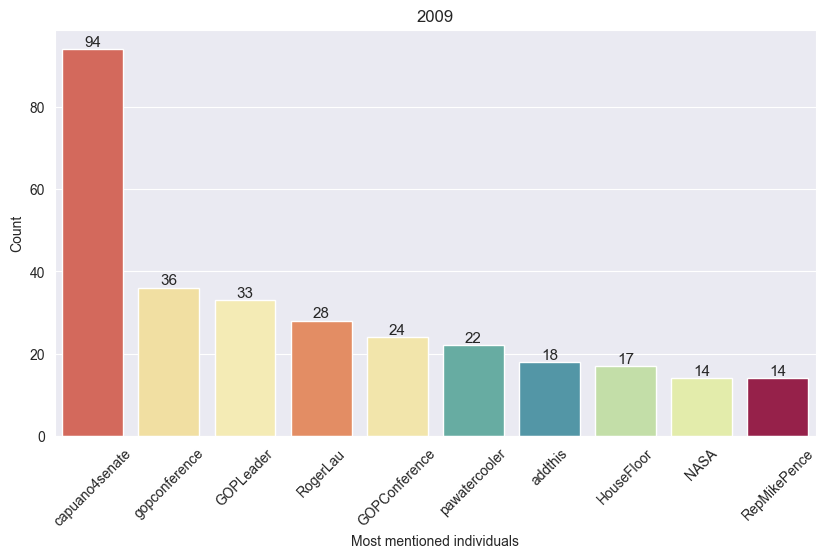

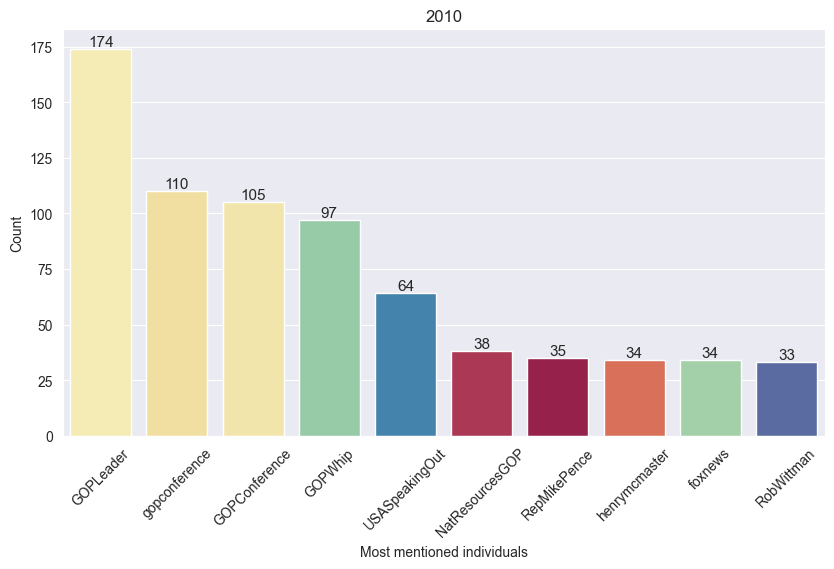

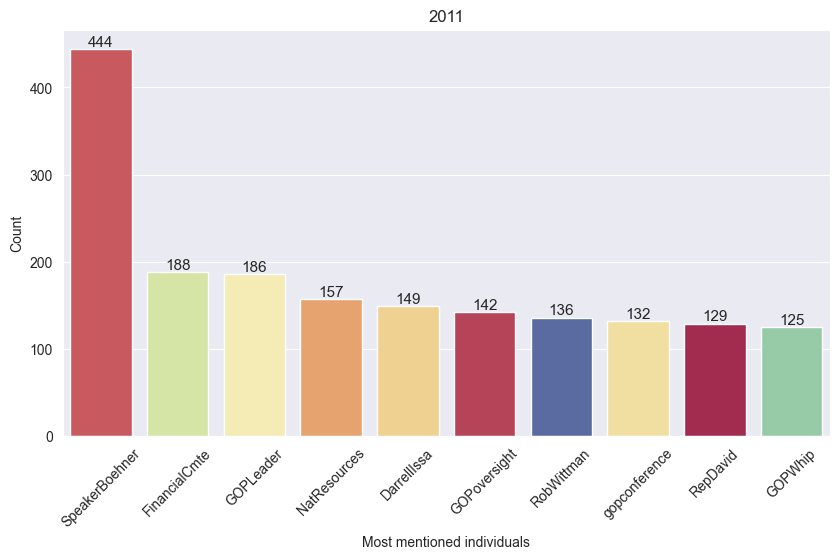

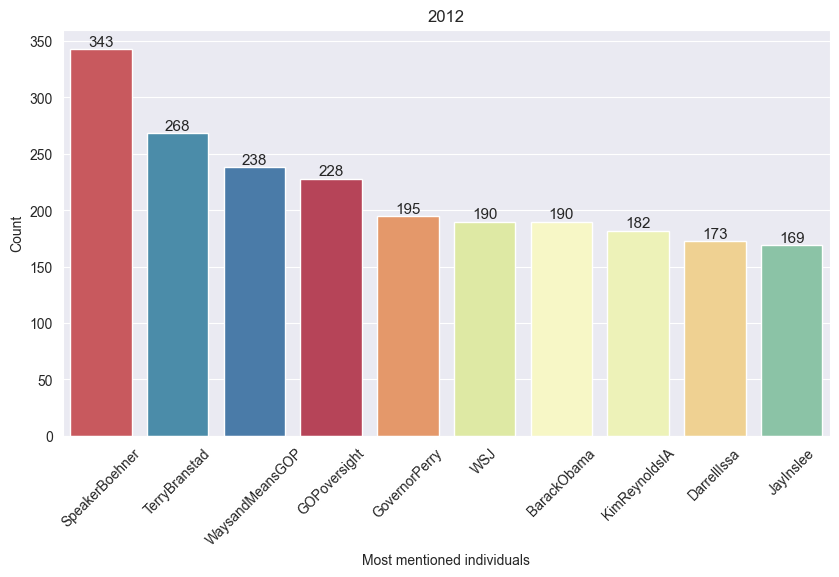

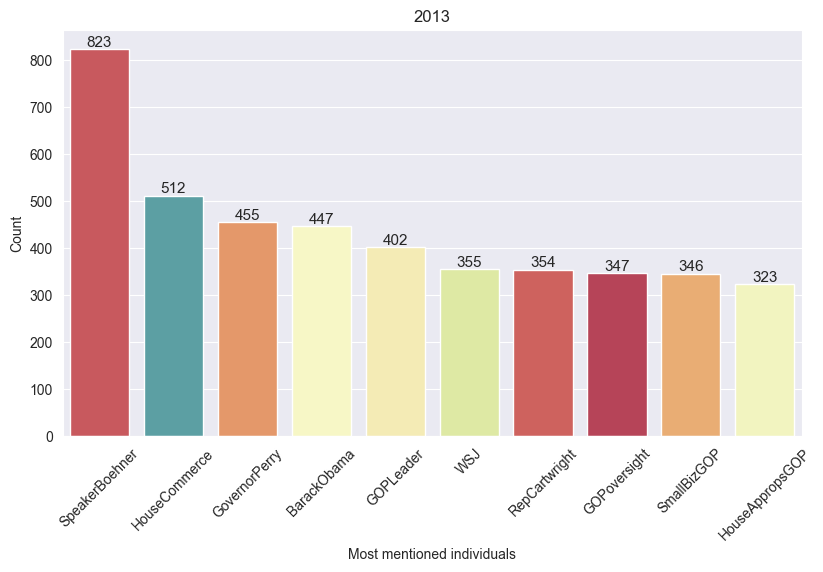

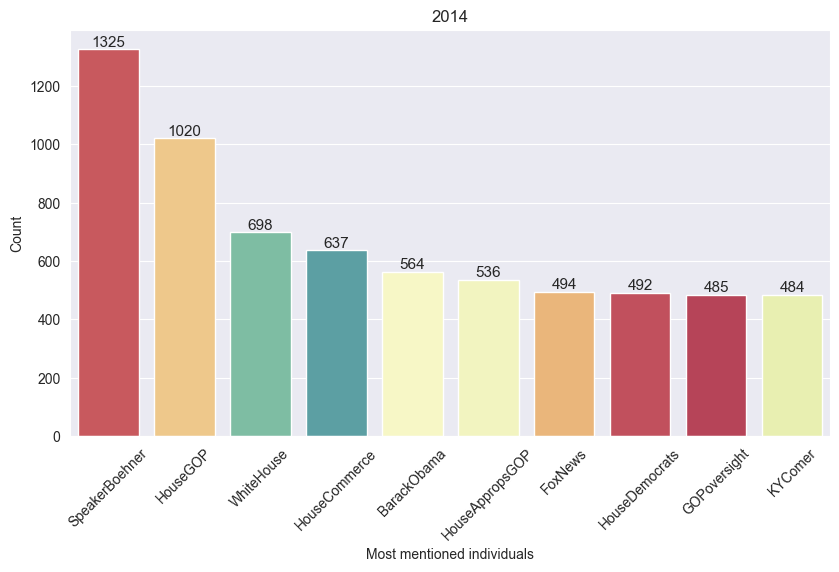

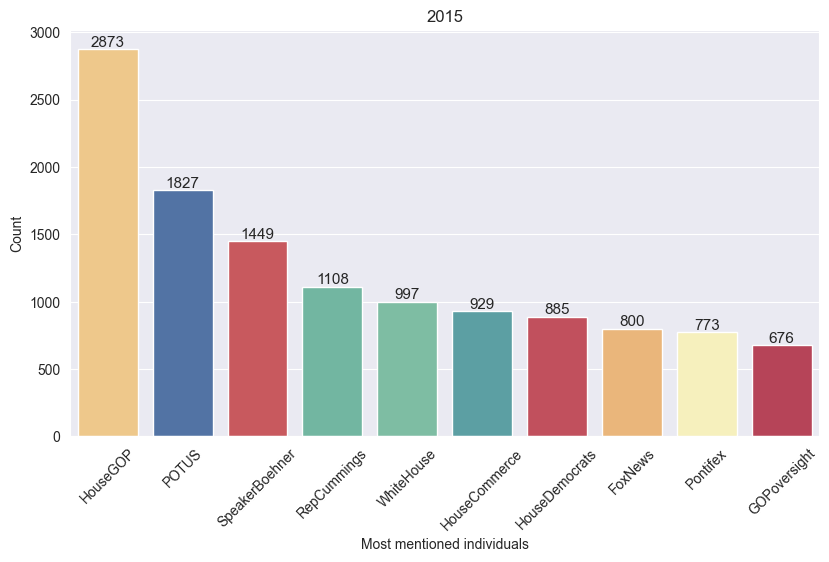

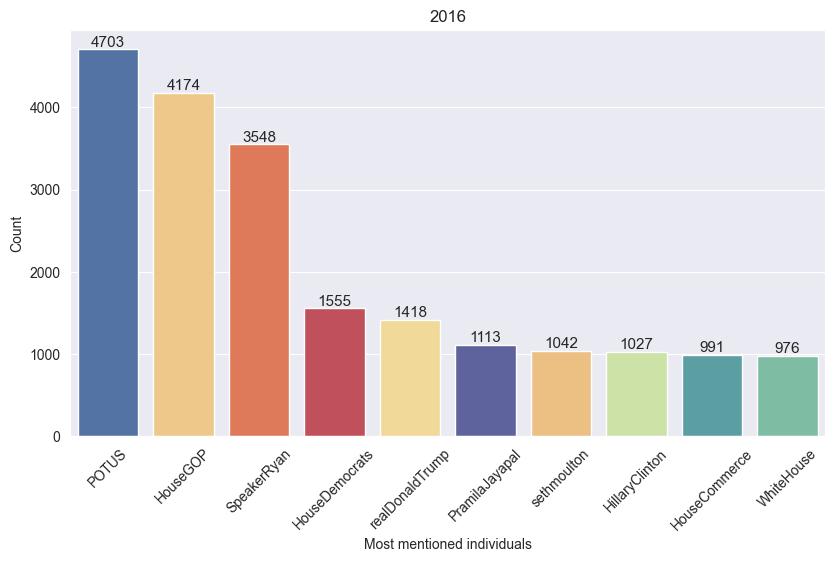

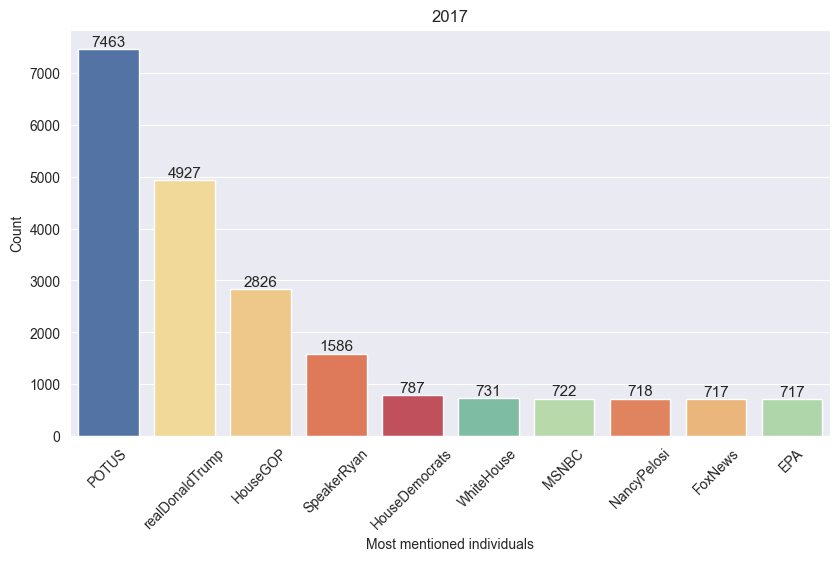

In [21]:
year = list(df['year'].unique())
keep_save = []
for t in year:
    df_ = df[df['year']==t]
    fig, ax = plt.subplots(figsize=(8.5, 5))
    sns.set_style('darkgrid')
    sns.barplot(data = df_,
                x = 'handle', y ='count',
                order = df_.sort_values('count', ascending=False)['handle'],
                palette=dict_color)
    ax.bar_label(ax.containers[0],
                 labels=df_.sort_values('count', ascending=False)['count'],
                 label_type='edge', size=11)
    plt.ylabel('Count')
    plt.xlabel('Most mentioned individuals')
    plt.title(t)
    plt.tight_layout()

    # set the x-tick labels
    ax.set_xticklabels(df_.sort_values('count', ascending=False)['handle'], rotation=45)
    s_name = str(t) + '_bar.png'
    keep_save.append(s_name)
    plt.show()